# Time Offset between Clocks
* We want to measure the timing offset between Alice and Bob using 2 independent SPDC sources.
* Each party makes a local measurement using one of thier photons in a pair, the other photon is sent across a fibre. 
* Coincidence times between Alice and Bob's detectors contain information about the fibre length, and clock offsets.
* We measure the time series for 5, 30, 80 m fibre lengths in a single acquisition.
* Using Christian's pfindblurb, we locate the timing offset efficiently using fft, but suffer high signal-to-noise as one of the time series is 'folded' to improve processing speed.
* To have higher signal-to-noise, we use the output of pfindblurb to shift Bob's time series so that it is almost synchronised with Alice's. Hence, we can perform a g2 for a shorter range of time separation, without folding any of the time series.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import peakutils
from qitdevices.g2lib.g2_lib import _data_extractor as data_extractor
from qitdevices.g2lib.g2_lib import delta_loop
%matplotlib notebook
%matplotlib notebook

# Import Data

In [19]:
data_directory='/home/jianwei/Projects/clocksync/data/20171228_twosource_80_30_5m_300s'
alice_raw='/home/jianwei/Projects/clocksync/data/20171228_twosource_80_30_5m_300s/20171228_221956Alice_fibrelength_803005.raw'
bob_raw='/home/jianwei/Projects/clocksync/data/20171228_twosource_80_30_5m_300s/20171228_221956Bob_fibrelength_803005.raw'

In [20]:
ta,pa = data_extractor(alice_raw)
tb,pb = data_extractor(bob_raw)

<IPython.core.display.Javascript object>


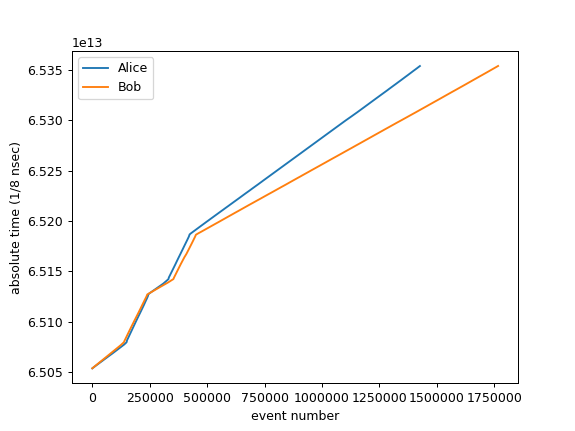

In [21]:
# Plot the time series to observe when the fibre lengths have changed
plt.figure()
plt.plot(ta[:],label='Alice')
plt.plot(tb[:],label='Bob')
plt.xlabel('event number')
plt.ylabel('absolute time (1/8 nsec)')
plt.legend()
plt.show()

In [23]:
# offset found with pfindblurb (ms)
101685184/8 * 1e-9 * 1e3

12.710648

# Data Organisation
* The data consists of 3 segments: that obtained with 80m, 30m and 5 m sections. 
* Here, we seperate them to improve the eventual signal-to-noise

In [25]:
ta_80 = ta[:134343]
tb_80 = tb[:134343]

In [26]:
ta_30 = ta[245326:330159]
tb_30 = tb[241084:351367]

In [27]:
ta_5 = ta[429143:585198]
tb_5 = tb[481578:655111]

# Time Shift
* Shift Bob's timings by offset so that g2 program does not have to process a huge range of time differences

In [28]:
offset = (101685184/8)+4000 #(ns) first term: from pfindblurb. second term: enough range to observe the other peak
print(offset)

12714648.0


In [29]:
tb_80_shifted = tb_80+offset

In [30]:
tb_30_shifted = tb_30+offset

In [31]:
tb_5_shifted = tb_5+offset

# G2
* perform g2 with shifted data
* convert back to unshifted data 'by hand'

In [32]:
# g2 with shifted data
# delta_loop returns (tb_shifted - ta) = tb + offset - ta
# we remove the offset from the output of delta_loop and call it delta_time
delta_time_80 = np.array(delta_loop(ta_80,tb_80_shifted,max_range=8000)) - offset
delta_time_30 = np.array(delta_loop(ta_30,tb_30_shifted,max_range=8000)) - offset
delta_time_5 = np.array(delta_loop(ta_5,tb_5_shifted,max_range=8000)) - offset

<IPython.core.display.Javascript object>


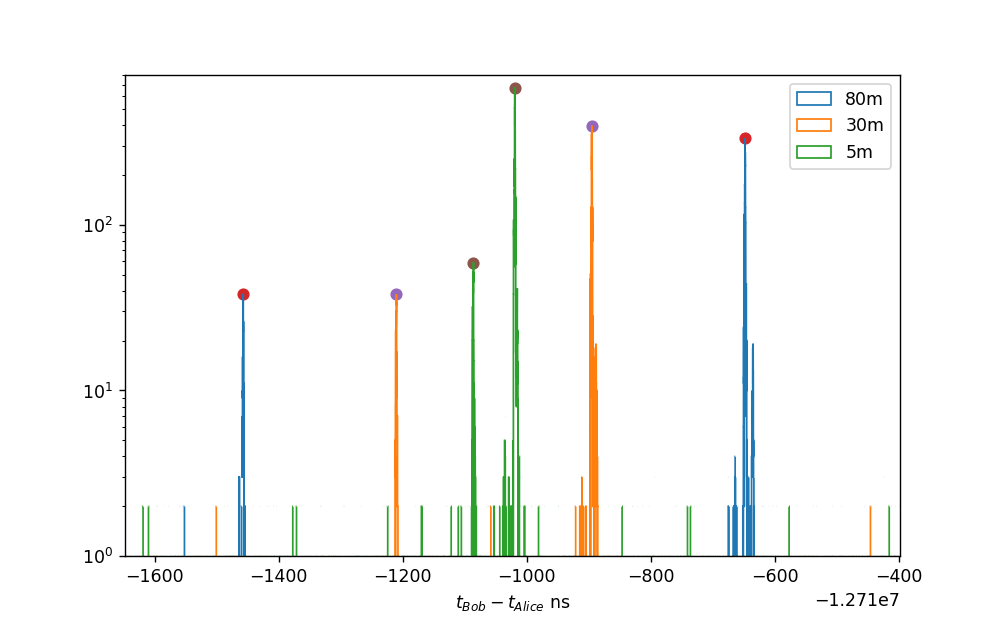

[-12711457.375 -12710648.   ] [  38.  333.]
[-12711210.25 -12710895.  ] [  38.  393.]
[-12711086.    -12711019.375] [  59.  668.]


In [89]:
# G2 histogram with peak detection
dt_low=3000-offset
dt_high=4250-offset
dt=1/8. #ns
numbins=int((dt_high-dt_low)/dt)

plt.figure(figsize=(8,5))
n80,bins,_ = plt.hist(delta_time_80,bins=numbins,range=(dt_low,dt_high),label='80m',histtype='step')
n30,_,_ = plt.hist(delta_time_30,bins=numbins,range=(dt_low,dt_high),label='30m',histtype='step')
n5,_,_ = plt.hist(delta_time_5,bins=numbins,range=(dt_low,dt_high),label='5m',histtype='step')
plt.xlabel(r'$t_{Bob}-t_{Alice}$ ns')
plt.xlim(dt_low,dt_high)

indexes80 = peakutils.indexes(n80,thres=0.1,min_dist=600)
plt.scatter(bins[indexes80],n80[indexes80])
print(bins[indexes80],n80[indexes80])

indexes30 = peakutils.indexes(n30,thres=0.01,min_dist=300)
plt.scatter(bins[indexes30],n30[indexes30])
print(bins[indexes30],n30[indexes30])

indexes5 = peakutils.indexes(n5,thres=0.001,min_dist=50)
indexes5 = indexes5[n5[indexes5]>50]
plt.scatter(bins[indexes5],n5[indexes5])
print(bins[indexes5],n5[indexes5])

plt.ylim(1,800)
plt.legend(loc='best')
plt.semilogy()
plt.show()

# Result: Timing Offset between Alice and Bob

In [98]:
print('Offset Times (Bob - Alice):')
print('From 80 m fibre: %f ns' % np.mean(bins[indexes80]))
print('From 30 m fibre %f ns' % np.mean(bins[indexes30]))
print('From 5 m fibre %f ns' % np.mean(bins[indexes5]))

Offset Times (Bob - Alice):
From 80 m fibre: -12711052.687500 ns
From 30 m fibre -12711052.625000 ns
From 5 m fibre -12711052.687500 ns


# Appendix

## A.1 Distance checks
* We verify that the time separation between 2 g2 peaks (from the same fibre length acquisition) correspond to the length used.
* In addition to the fibre, we need to the take fibre beam splitter (FBS) fibre lengths into account when comparing with the seperation between the 2 sources.
* To obtain the additional time delay (fbs_offset) due to the FBS, we use the oscilloscope to obtain a similar graph with 0 m of fibre between the 2 sources.
* We verify that the measured time separations are consistent with the fibre lengths by calculating time difference ratios and verifying that they are equal to the length ratios.

In [99]:
fbs_offset = 16.7484400161 #ns interpeak separation with 0 m of fibre obtained independently from Lecroy + gaussian fit
dt80=(np.diff(bins[indexes80]))[0]
dt30=(np.diff(bins[indexes30]))[0]
dt5=(np.diff(bins[indexes5]))[0]

print('measured time difference ratios, expected ratios:')
print((dt80-fbs_offset)/(dt5-fbs_offset), 80/5)
print((dt30-fbs_offset)/(dt5-fbs_offset), 30/5)
print((dt80-fbs_offset)/(dt30-fbs_offset), 80/30)

measured time difference ratios, expected ratios:
15.8917647937 16.0
5.98480649187 6.0
2.65535148301 2.6666666666666665


## A.2 Index of Refraction check
* Sanity check to make sure that the timing separation is consistent with the index of refraction of the fibre.

In [101]:
c = 299792458
n = (c * (dt5-fbs_offset) / 2 * 1e-9) / 5
print('index of refraction = {:.2f} @ 810 nm'.format(n))
print('(Nufern Core Index Of Refraction. 1.4586 ± 0.0004 @ 850 nm is close)')

index of refraction = 1.50 @ 810 nm
(Nufern Core Index Of Refraction. 1.4586 ± 0.0004 @ 850 nm is close)


# to improve: 
*gaussian fit of timestampcard data also since time ratios have errors of about 0.6%